GREYSCALE


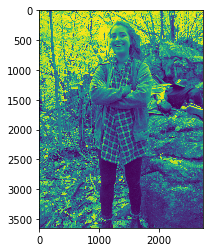

In [1]:
%matplotlib inline
import cv2 as cv2
import matplotlib.pyplot as plt

def displayGrey(im,desc=""):
    print desc
    plt.imshow(im)
    
def harrisCorners(im):
    #First convert the image to greyscale
    displayGrey(im,"GREYSCALE")
    
    

image = cv2.imread("./Assignment2/images/Rebecca1.jpg",0)
harrisCorners(image)